<a href="https://colab.research.google.com/github/JackBstn/Chronos_multivariate/blob/main/chronos_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Trading Simulation

This Colab notebook implements a trading strategy that leverages our pre-trained neural network for stock price prediction (remember that the *goal of the neural network* is to join the predictions made by the Chronos model for each dimension into a single prediction for the next day's closing price). The objective is to use these predictions to make trading decisions and compare the performance against a traditional Buy & Hold strategy, the default Chronos (zero-shot), and the fine-tuned version (1000 epochs). Trading decisions (BUY, SELL, HOLD) are based on the predicted percentage change in price. Each strategy's portfolio value is compared against a Buy & Hold benchmark.

#### Model & Data
- Data Source: Historical stock data retrieved from Yahoo Finance.
- Features Used: Open, High, Low, Volume, and Close prices.

#### Trading Logic

1. Decision-Making Rules
   - If the predicted price is at least 0.1% higher than the current price → *BUY* (if capital is available).
   - If the predicted price is at least 0.1% lower than the current price → *SELL* (if shares are held).
   - Otherwise, *HOLD* the position.

2. Portfolio Update: The portfolio value is updated daily, considering both cash and held shares.

#### Final Evaluation
At the end of the simulation:
- The total portfolio value is computed.
- A performance comparison is made against the Buy & Hold strategy.


### Install Dependencies

In [ ]:
!pip install torch chronos yfinance matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!git clone https://github.com/JackBstn/NLP.git

In [2]:
import torch
import numpy as np
import torch.nn as nn
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline, ChronosPipeline

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
seed = 343126


def reset_seed():
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

#### Import pre-trained NN, Chronos (Zero-Shot), and Chronos (Fine-Tuned) models

In [3]:
class PricePredictionNN(nn.Module):
    """
    Neural Network for price prediction.
    Architecture: 3 fully connected layers with ReLU activation and dropout.
    """

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(PricePredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
reset_seed()  # For reproducibility

# Model
input_size = 5  # Feature number
hidden_size_1 = 128  # Number of hidden units in first hidden layer
hidden_size_2 = 64  # Number of hidden units in second hidden layer
output_size = 1  # Output size (1 for regression)
model = PricePredictionNN(input_size, hidden_size_1, hidden_size_2, output_size)

# Recover training scaler
data = np.load("Chronos_multivariate/models/chronos_dataset_nn.npz")
X_training = data["X"]
Y_training = data["Y"]
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X_training)
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y_training)

# Load the trained NN model
model.load_state_dict(torch.load("Chronos_multivariate/models/nn_model.pth"))
model.eval()

# Chronos model (Zero-Shot)
zero_shot_pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-tiny", device_map="cuda", torch_dtype=torch.bfloat16)

# Fine-tuned Chronos model
!unzip -o NLP/models/finetuned_model_1000.zip # Change the name of the zip file if needed (e.g., finetuned_model_1000.zip, finetuned_model_10000.zip)
fine_tuned_pipeline = ChronosPipeline.from_pretrained("finetuned_model")


# ---- Functions to predict the next value using the models ----
# The following 3 functions are used to predict the next value using the Chronos model, the NN model, or both, given a context.

def predict_chronos_only(context, use_finetuned=False):
    """ Use only the Close price with Chronos to predict the next value """
    context_close = context["Close"].values
    if use_finetuned:
        forecast = fine_tuned_pipeline.predict(context=torch.tensor(context_close), prediction_length=1)
    else:
        forecast = zero_shot_pipeline.predict(context=torch.tensor(context_close), prediction_length=1)
    return np.mean(forecast[0].numpy(), axis=0)[0]


def predict_chronos_and_nn(context, use_finetuned=False):
    """ Use Chronos to predict the next value for all the variables, and then the NN to join them into an univariate """

    # Apply Chronos on each covariate (each column of the context)
    covariate_predictions = []
    for i in range(context.shape[1]):  # Each covariate
        context_cov = torch.tensor(context.iloc[:, i].values, dtype=torch.float32)  # Use only one covariate

        # Predict the next day
        if use_finetuned:
            forecast = fine_tuned_pipeline.predict(context=context_cov, prediction_length=1)
        else:
            forecast = zero_shot_pipeline.predict(context=context_cov, prediction_length=1)

        mean = np.mean(forecast[0].numpy(), axis=0)  # Distribution mean
        covariate_predictions.append(mean)

    # Scale and convert to PyTorch tensor
    covariate_predictions = scaler_x.transform(np.array(covariate_predictions).T)
    covariate_predictions = torch.tensor(covariate_predictions, dtype=torch.float32)

    # Apply the NN model to join the covariate predictions (5x1) into a univariate prediction (1)
    with torch.no_grad():
        forecast = model(covariate_predictions)

    # Rescale the forecast
    forecast = scaler_y.inverse_transform(forecast.numpy())
    return forecast.item()

#### Download test data

In [5]:
# Download Yahoo Finance data
# Note: I use 3 months as context to predict the next day, using a sliding window approach.
# Start with the first 3 months, predict the next day.
# Then, add the real value for the next day to the context, remove the first of the window, and repeat.
# This is why I need to download more than 3 months of data.

symbol = "AAPL"
data = yf.download(symbol, start="2023-11-01", end="2024-04-30", progress=False)

# Sort columns to []"Open", "High", "Low", "Volume", "Close"].
# This is important because the order of inputs for the NN is fundamental!
data = data[["Open", "High", "Low", "Volume", "Close"]]

# Prepare the dataset: extract features and closing prices
close_prices = data["Close"].values.ravel()

### Trading bot


------------ Testing Chronos Zero-Shot ------------
Day 1: Actual Price = 170.51€, Predicted Price = 166.56€, Diff = -2.32%, Action = HOLD
Day 2: Actual Price = 172.38€, Predicted Price = 158.62€, Diff = -7.98%, Action = HOLD
Day 3: Actual Price = 172.00€, Predicted Price = 280.39€, Diff = 63.02%, Action = BUY
Day 4: Actual Price = 173.09€, Predicted Price = 171.40€, Diff = -0.98%, Action = SELL
Day 5: Actual Price = 175.45€, Predicted Price = 175.66€, Diff = 0.12%, Action = BUY
Day 6: Actual Price = 178.03€, Predicted Price = 426.28€, Diff = 139.45%, Action = HOLD
Day 7: Actual Price = 170.75€, Predicted Price = 180.88€, Diff = 5.93%, Action = HOLD
Day 8: Actual Price = 171.66€, Predicted Price = 313.19€, Diff = 82.45%, Action = HOLD
Day 9: Actual Price = 170.23€, Predicted Price = 162.33€, Diff = -4.64%, Action = SELL
Day 10: Actual Price = 169.10€, Predicted Price = 178.73€, Diff = 5.70%, Action = BUY
Day 11: Actual Price = 172.69€, Predicted Price = 179.69€, Diff = 4.05%, Action =

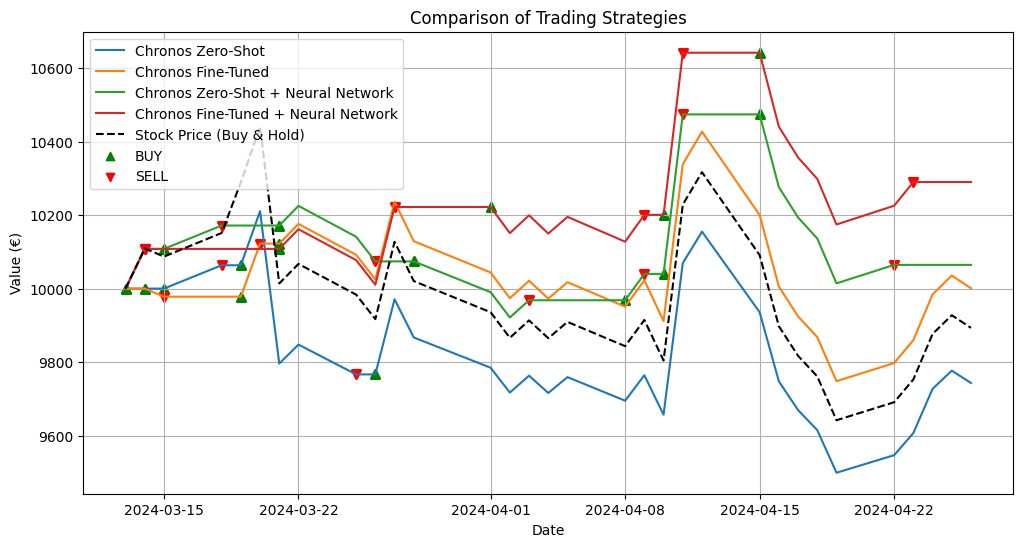

In [6]:
combinations_to_test = [
    ("Chronos Zero-Shot", predict_chronos_only, False),
    ("Chronos Fine-Tuned", predict_chronos_only, True),
    ("Chronos Zero-Shot + Neural Network", predict_chronos_and_nn, False),
    ("Chronos Fine-Tuned + Neural Network", predict_chronos_and_nn, True)
]

reset_seed()  # For reproducibility
threshold_percent = 0.1  # Percentage threshold to trigger a trade
context_size = 90  # Number of days to use as context for the prediction
plt.figure(figsize=(12, 6))

for name, predictor_fn, use_finetuned in combinations_to_test:
    # Initialize capital and variables for the simulation
    budget = 10000.0  # Initial capital in €
    shares_held = 0  # Number of shares currently held
    portfolio_values = []  # List to store daily portfolio value
    actions_taken = []  # List to record trading decisions (BUY, SELL, HOLD)

    print(f"\n------------ Testing {name} ------------")

    # Simulation loop: iterate from the first day after the context period until the end of the data
    for day in range(context_size, len(data) - 1):  # Day is the index of the next day (to predict)

        # Extract the context for the current day
        context = data.iloc[day - context_size:day]  # 90 days of context, not including the current day
        real_close_price = close_prices[day]  # Real closing price for the day to predict

        # Predict the price for the next trading day
        predicted_price = predictor_fn(context, use_finetuned)

        # Compute the percentage difference between the predicted and actual price
        percent_diff = ((predicted_price - real_close_price) / real_close_price) * 100

        # Default decision is HOLD
        decision = "HOLD"

        # Trading strategy:
        # - If the predicted price is at least threshold% higher than the current price, buy
        # - If the predicted price is at least threshold% lower than the current price, sell (if shares are held)
        if percent_diff > threshold_percent and budget >= real_close_price:
            # Buy as many shares as possible with the available budget
            shares_to_buy = int(budget // real_close_price)
            budget -= shares_to_buy * real_close_price
            shares_held += shares_to_buy
            decision = "BUY"
        elif percent_diff < -threshold_percent and shares_held > 0:
            # Sell all currently held shares
            budget += shares_held * real_close_price
            shares_held = 0
            decision = "SELL"

        actions_taken.append(decision)
        # Compute the current portfolio value (cash + value of held shares)
        portfolio_value = budget + (shares_held * real_close_price)
        portfolio_values.append(portfolio_value)

        # Print daily trading details
        print(f"Day {day - context_size + 1}: Actual Price = {real_close_price:.2f}€, Predicted Price = {predicted_price:.2f}€, Diff = {percent_diff:.2f}%, Action = {decision}")

    # Plot the portfolio value over time and compare it to a Buy & Hold strategy
    plt.plot(data.index[context_size:-1], portfolio_values, label=name)

    # Place a marker for each trading action (BUY='^', SELL='v')
    for i, action in enumerate(actions_taken):
        if action == "BUY":
            plt.scatter(data.index[context_size + i], portfolio_values[i], marker="^", color="green", linewidths=2)
        elif action == "SELL":
            plt.scatter(data.index[context_size + i], portfolio_values[i], marker="v", color="red", linewidths=2)

    # Final portfolio value at the end of the simulation period
    final_value = budget + (shares_held * close_prices[-1])
    print(f"\nFinal Portfolio Value: {final_value}€")

# Buy & Hold strategy: Assume all capital was invested on the first day of the forecasting period
close_prices_forecasting_period = data["Close"].values.ravel()[context_size:]
buy_hold_values = close_prices_forecasting_period[:-1] * (10000 / close_prices_forecasting_period[0])
plt.plot(data.index[context_size:-1], buy_hold_values, label="Stock Price (Buy & Hold)", linestyle="dashed", color='black')

# Add legend also for the Buy & Hold marks (^, v)
plt.scatter([], [], marker="^", color="green", label="BUY")
plt.scatter([], [], marker="v", color="red", label="SELL")

plt.xlabel("Date")
plt.ylabel("Value (€)")
plt.grid()
plt.title("Comparison of Trading Strategies")
plt.legend()
plt.show()